In [2]:
from dotenv import load_dotenv
from IPython.display import Markdown, display
load_dotenv()  # loads .env into this process

import os, pandas as pd, sqlalchemy as sa, psycopg

# Build engine 
engine = sa.create_engine(
    f"postgresql+psycopg://{os.getenv('PGUSER')}:{os.getenv('PGPASSWORD')}@"
    f"{os.getenv('PGHOST')}:{os.getenv('PGPORT')}/{os.getenv('PGDATABASE')}"
)

In [3]:
# Helper function to make queries easier 
def q(sql):
    return pd.read_sql(sql, engine)

In [4]:
# Row counts + distinct IDs
q("""
SELECT
    COUNT(*) AS rows,
    COUNT(DISTINCT source_id) AS distinct_ids
FROM raw.chicago_crimes;
""")

,rows,distinct_ids
0,5801,5801


In [5]:
# Look at crime types inside JSON
q("""
SELECT payload ->> 'primary_type' AS crime_type, COUNT(*) AS n
FROM raw.chicago_crimes
GROUP BY 1
ORDER BY n DESC
LIMIT 25;
""")

,crime_type,n
0,THEFT,1209
1,BATTERY,1126
2,CRIMINAL DAMAGE,589
3,ASSAULT,522
4,MOTOR VEHICLE THEFT,414
5,OTHER OFFENSE,407
6,DECEPTIVE PRACTICE,366
7,BURGLARY,263
8,NARCOTICS,186
9,ROBBERY,157


In [6]:
q("""
SELECT primary_type, COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
GROUP BY 1
ORDER BY n DESC
LIMIT 25;
""")

,primary_type,n
0,THEFT,1209
1,BATTERY,1126
2,CRIMINAL DAMAGE,589
3,ASSAULT,522
4,MOTOR VEHICLE THEFT,414
5,OTHER OFFENSE,407
6,DECEPTIVE PRACTICE,366
7,BURGLARY,263
8,NARCOTICS,186
9,ROBBERY,157


In [7]:
# Time coverage 
q("""
SELECT 
    MIN(date) AS first_record,
    MAX(date) AS last_record,
    COUNT(*) AS total_rows
FROM public_stg.stg_chicago_crimes;
""")

,first_record,last_record,total_rows
0,2001-08-26 11:45:00,2025-09-05,5801


In [8]:
# Monthly trends by crime type 
q("""
SELECT 
    DATE_TRUNC('month', date) AS month,
    primary_type,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
GROUP BY 1,2
ORDER BY month, n DESC;
""")


,month,primary_type,n
0,2001-08-01,CRIMINAL TRESPASS,1
1,2001-08-01,CRIMINAL SEXUAL ASSAULT,1
2,2001-08-01,CRIMINAL DAMAGE,1
3,2001-11-01,CRIMINAL SEXUAL ASSAULT,1
4,2004-03-01,DECEPTIVE PRACTICE,1
...,...,...,...
195,2025-09-01,HOMICIDE,2
196,2025-09-01,PROSTITUTION,2
197,2025-09-01,CONCEALED CARRY LICENSE VIOLATION,1
198,2025-09-01,OBSCENITY,1


In [9]:
# Arrest rates 
q("""
SELECT 
  primary_type,
  COUNT(*) AS total,
  SUM(CASE WHEN arrest THEN 1 ELSE 0 END) AS arrests,
  ROUND(100.0 * SUM(CASE WHEN arrest THEN 1 ELSE 0 END) / COUNT(*), 2) AS arrest_rate_pct
FROM public_stg.stg_chicago_crimes
GROUP BY primary_type
ORDER BY total DESC
LIMIT 15;
""")
  

,primary_type,total,arrests,arrest_rate_pct
0,THEFT,1209,109,9.02
1,BATTERY,1126,186,16.52
2,CRIMINAL DAMAGE,589,23,3.90
3,ASSAULT,522,64,12.26
4,MOTOR VEHICLE THEFT,414,7,1.69
5,OTHER OFFENSE,407,71,17.44
6,DECEPTIVE PRACTICE,366,15,4.10
7,BURGLARY,263,11,4.18
8,NARCOTICS,186,175,94.09
9,ROBBERY,157,14,8.92


In [10]:
# Location hot spots 
q("""
SELECT
    location_description,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
GROUP BY location_description
ORDER BY n DESC
LIMIT 15;
""")

,location_description,n
0,STREET,1504
1,APARTMENT,1087
2,RESIDENCE,715
3,SIDEWALK,355
4,PARKING LOT / GARAGE (NON RESIDENTIAL),219
5,SMALL RETAIL STORE,192
6,ALLEY,147
7,DEPARTMENT STORE,129
8,RESTAURANT,105
9,VEHICLE NON-COMMERCIAL,103


In [ ]:
# Trend over time by major crime categories 
q("""
SELECT DATE_TRUNC('year', date) AS year,
  primary_type,
  COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE primary_type IN ('THEFT', 'BATTERY', 'ASSAULT', 'BURGLARY', 'NARCOTICS')
GROUP BY 1,2
ORDER BY year, n DESC;
""")


,year,primary_type,n
0,2010-01-01,BATTERY,1
1,2017-01-01,BATTERY,1
2,2019-01-01,BATTERY,1
3,2021-01-01,BATTERY,1
4,2022-01-01,BATTERY,2
5,2022-01-01,ASSAULT,1
6,2023-01-01,THEFT,1
7,2024-01-01,BATTERY,6
8,2024-01-01,ASSAULT,2
9,2024-01-01,BURGLARY,2


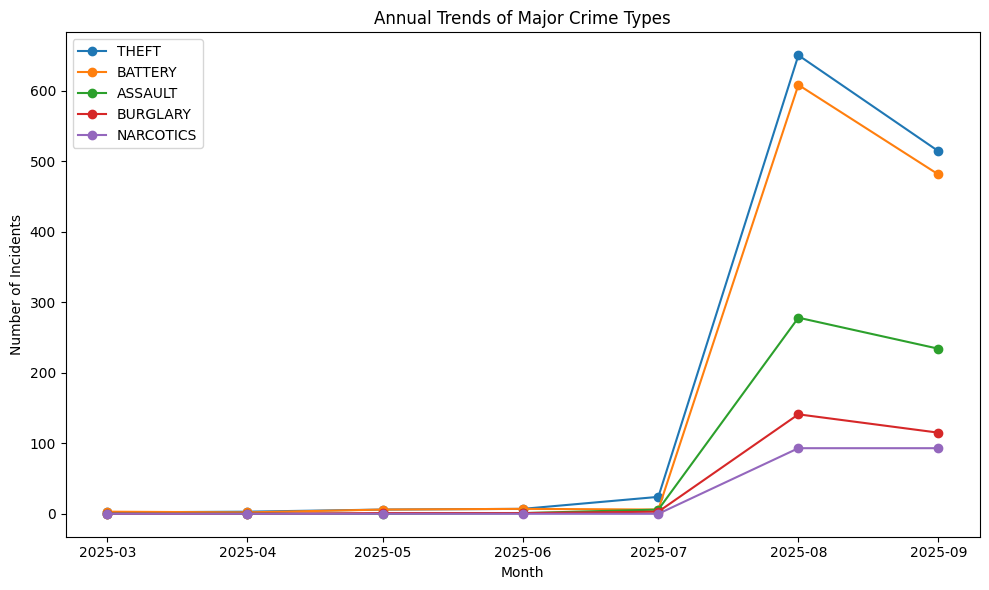

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = q("""
SELECT DATE_TRUNC('month', date) AS month,
       primary_type,
       COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE date >= '2024-01-01'
    AND primary_type IN ('THEFT','BATTERY','ASSAULT','BURGLARY','NARCOTICS')
GROUP BY 1,2
ORDER BY month, n DESC;
""")

# Ensure datetime and tidy index
df['month'] = pd.to_datetime(df['month']).dt.to_period('M').dt.to_timestamp()

# Filter for recent incidents 
recent = df[df['month'] >= "2025-03-01"]

# Pivot so each column is a crime type, rows are months
pivot = (recent
         .pivot_table(index='month', columns='primary_type', values='n', aggfunc='sum')
         .sort_index()
         .fillna(0))

# Limit to top 5 columns by total count
top_cols = pivot.sum().sort_values(ascending=False).head(5).index
pivot = pivot[top_cols]

plt.figure(figsize=(10,6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker='o', label=col)

plt.title("Annual Trends of Major Crime Types")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.legend()
plt.tight_layout()
plt.show()